In [1]:
# Edgar new data Jan 2024

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import pathlib
from pathlib import Path

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from models import *
from utils import *


seed = 2468
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())

NVIDIA GeForce RTX 3090


In [2]:
'''
The imaging is still at 30hz.
The ephys is binarized in 1ms bins.
The speed has corresponding triggers in imaging and ephys.
I.e. for every entry in the speed file, there is a corresponding imaging frame or ephys bin at the given index.
There are files for baseline and for stimulation. In each case, the imaging ROIs and the ephys units are matched.
I.e. index 1 in baseline imaging is the same cell as index 1 is stim imaging.

Please see if this format works for you. Let me know if you want me to downsample all of them to the same frame rate (30Hz) instead if that is easier for you. If this runs ok, then I can run another 1-2 mice through which should put us at 3-4 animals. I will work on getting the combinatorial paradigm in place as well, but it is a little bit complicated right now.
'''
parent_path = Path('./data/EB095/')
stim_path = parent_path / "EB095_stim/"
run_path = parent_path / "EB095_run/"


area_ID_ephys = np.load(run_path / 'area_ID_ephys.npy')        # (106,) 8 LS, 70 ACC
dff_run = np.load(run_path / 'dff_run.npy')                    # (294, 32727) GCaMP when running
dff_stim = np.load(stim_path /'dff_stim.npy')                  # (294, 94696) GCaMP when stimulated 
spks_run = np.load(run_path / 'spks_run.npy')                  # (106, 32727)
spks_stim = np.load(stim_path /'spks_stim.npy')                # (106, 94096)
speed_run = np.load(run_path / 'speed_run.npy')                # (32727,) max 13

# speed_triggers_ephys_run = np.load(run_path / 'speed_triggers_ephys_run.npy')  # (56322)
# speed_triggers_img_run = np.load(run_path / 'speed_triggers_img_run.npy')      # (56322)
stim_ID = np.load(stim_path /'stim_ID.npy')
stim_ID_resolved = np.load(stim_path /'stim_ID_resolved.npy')  # (300, 6), R S or F
stim_time = np.load(stim_path /'stim_triggers.npy')            # (300, )

Exploratory analysis: Running vs Activity

(array([21162.,  1118.,  1187.,  1286.,  1532.,  2066.,  2008.,  1546.,
          689.,   133.]),
 array([ 0.        ,  1.47263641,  2.94527283,  4.41790924,  5.89054565,
         7.36318207,  8.83581848, 10.3084549 , 11.78109131, 13.25372772,
        14.72636414]),
 <BarContainer object of 10 artists>)

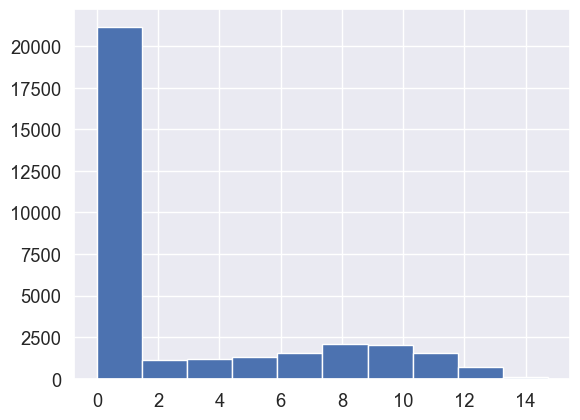

In [5]:
 # (106, 56322)
plt.hist(speed_run) # (56302)

In [53]:
from utils import rbf_rate_convolution_2d
spks_run_30Hz_smooth = rbf_rate_convolution_2d(spks_run_30Hz.T, sigma=0.1)
spks_run_30Hz_smooth = np.hstack((np.zeros((106,50)), spks_run_30Hz_smooth))
spks_run_30Hz_smooth = np.hstack(( spks_run_30Hz_smooth, np.zeros((106,50))))


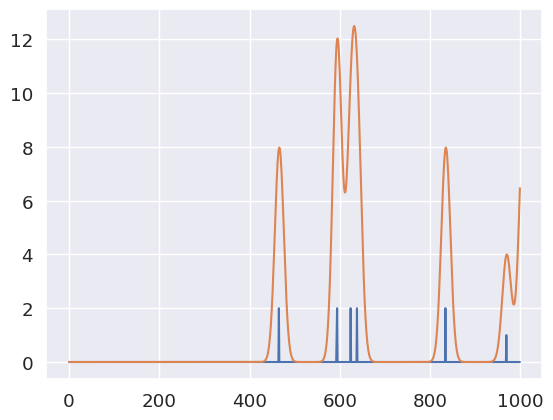

In [54]:
plt.plot(spks_run_30Hz[3,5000:6000])
plt.plot(spks_run_30Hz_smooth[3,5000:6000])

In [71]:
speed_triggers_ephys_run_30Hz = list(map(int, speed_triggers_ephys_run/freq))

Text(0, 0.5, 'Correlation')

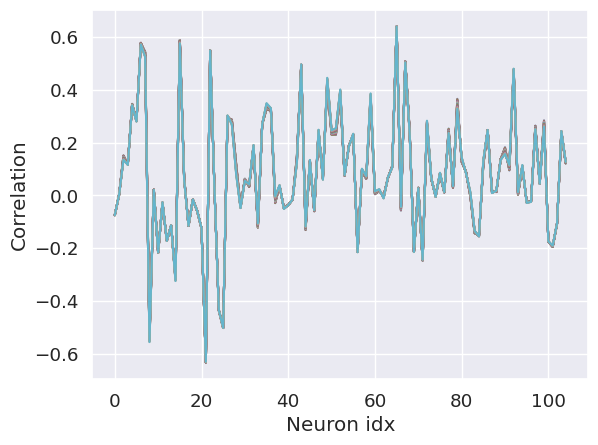

In [84]:
lag = 0

for lag in range(1, 21):
    corr = []
    for n in range(106):
        corr.append(np.corrcoef(spks_run_30Hz_smooth[n,speed_triggers_ephys_run_30Hz[lag:56322- (20-lag)]], speed_run)[0,1])
    plt.plot(corr[1:])
plt.xlabel('Neuron idx')
plt.ylabel('Correlation')

In [ ]:
spks_run_30Hz_smooth = rbf_rate_convolution_2d(spks_run_30Hz.T, sigma=0.1)
spks_run_30Hz_smooth = np.hstack((np.zeros((106,50)), spks_run_30Hz_smooth))
spks_run_30Hz_smooth = np.hstack(( spks_run_30Hz_smooth, np.zeros((106,50))))

Naive model fitting:
Ignore running / stationary, fit model to both data.

Convolve spikes

In [3]:
spks_stim_rates = rbf_rate_convolution_2d(spks_stim.T, sigma=0.1) # [93996, 106]
n_output_neurons, n_bins = spks_stim.shape
n_input_neurons = dff_stim.shape[0]
spks_stim_rates = torch.hstack([torch.zeros((n_output_neurons, 50)), spks_stim_rates, torch.zeros((n_output_neurons, 50))])

assert np.array(spks_stim_rates.shape).all() == np.array(spks_stim.shape).all()

spks_stim_rates = spks_stim_rates.T

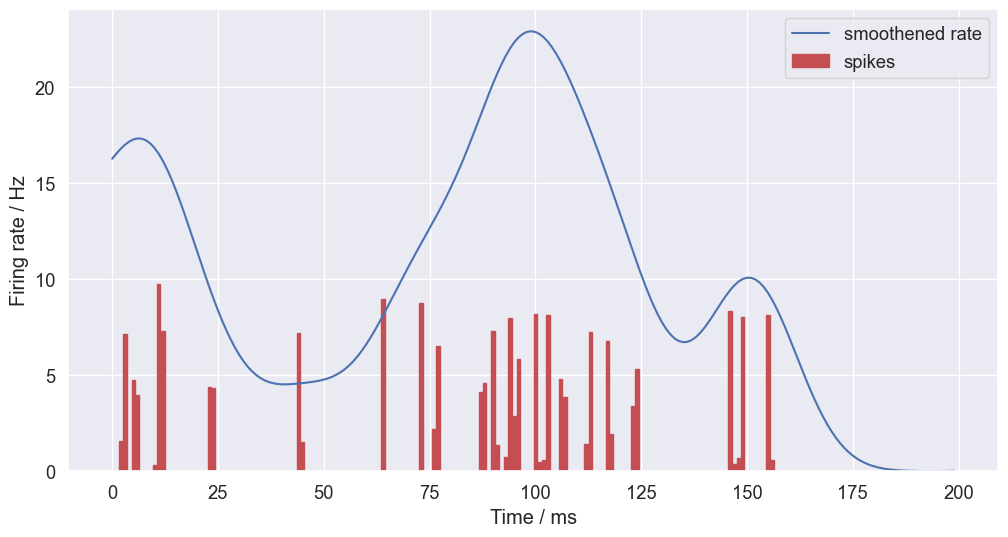

In [4]:
# visualise a sample of ephys smooth rates
_range = 200
_random_start = np.random.randint(0, n_bins-_range)
_random_neuron_idx = np.random.randint(0, n_output_neurons)

plt.figure(figsize=(12,6))
plt.plot(spks_stim_rates[_random_start:_random_start+_range, _random_neuron_idx], label='smoothened rate')
plt.bar(np.arange(200), height = spks_stim[_random_neuron_idx, _random_start:_random_start+_range] * spks_stim_rates[_random_start:_random_start+_range, _random_neuron_idx].mean().numpy(), color='r', edgecolor='r', label='spikes')
plt.ylabel('Firing rate / Hz')
plt.xlabel('Time / ms')
plt.legend()
plt.show()

# 10 time steps = 1 sigma = 330 ms

Data Pre-processing

In [5]:
tsteps = 15
cutoff_size = 2

if dff_stim.shape[0] != n_bins:
    dff_stim = dff_stim[:,:n_bins].T

assert dff_stim.shape[0] == spks_stim_rates.shape[0]

n_vecs = int(spks_stim_rates.shape[0] / tsteps)
input_dim = dff_stim.shape[1]
output_dim = spks_stim_rates.shape[1]
n_vecs = int(spks_stim_rates.shape[0]/tsteps)
n_stims = len(stim_ID)

# pre-process data into train and test sets
inputs, targets = torch.zeros(n_vecs, tsteps, input_dim), torch.zeros(n_vecs, 1, output_dim)
ephys_rates = torch.as_tensor(spks_stim_rates)
img_array = torch.as_tensor(dff_stim)
for n in range(1, n_vecs):
    inputs[n,:,:] = img_array[n*tsteps:(n+1)*tsteps,:]
    targets[n,:,:] = ephys_rates[n*tsteps-3:n*tsteps-2,:]

inputs = inputs[1:]
targets = targets[1:]

stim_vecs_idx = np.array([int(stim_time[i]/15) for i in range(n_stims)])

# edge case: last stim happens to be in the last bin.
stim_vecs_idx = stim_vecs_idx[:-1]

non_stim_vecs_idx = []

for i in range(cutoff_size, n_vecs-cutoff_size):
    flag = True
    for j in range(i-cutoff_size, i+cutoff_size):
        if j in stim_vecs_idx:
            flag = False
    if flag:
        non_stim_vecs_idx.append(i)

non_stim_vecs_idx = [i for i in range(cutoff_size, n_vecs-cutoff_size) if i not in stim_vecs_idx] # exclude padding steps

We sample 200 endogenous activity vectors, delete 4 vectors (4 * 15 * 33 = 2 secs) steps before and after.

In [6]:
test_set_idx = list(stim_vecs_idx)

# sample 200 endogenous data, chop off ends and add to test set
c = 0
while c < 200:
    endogenous_idx = np.random.choice(non_stim_vecs_idx)
    
    if np.all([x in non_stim_vecs_idx for x in range(endogenous_idx-cutoff_size, endogenous_idx+cutoff_size)]):
        c += 1
        for i in range(endogenous_idx-cutoff_size, endogenous_idx+cutoff_size):
            non_stim_vecs_idx.remove(i)
        test_set_idx.append(endogenous_idx)
    
X_train, Y_train = inputs[non_stim_vecs_idx], targets[non_stim_vecs_idx]
X_test, Y_test = inputs[test_set_idx], targets[test_set_idx]

Train for LS neurons only

In [7]:
area_ID_ephys

array(['Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other',
       'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other',
       'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other',
       'Other', 'Other', 'Other', 'Other', 'Other', 'LS', 'LS', 'LS',
       'LS', 'LS', 'LS', 'LS', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC',
       'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC',
       'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC',
       'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC',
       'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC',
       'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC',
       'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC',
       'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC',
       'Other', 'Other', 'LS', 'ACC'], dtype='<U5')

In [22]:
LS_neuron_idx = np.where(area_ID_ephys == 'LS')[0]
ACC_neuron_idx = np.where(area_ID_ephys == 'ACC')[0]
Others_neuron_idx = np.where(area_ID_ephys == 'Other')[0]
nLS_neuron_idx = np.where(area_ID_ephys != 'LS')[0]

forward_mse_idx = list(np.nonzero(np.array(stim_ID) == 'F')[0])
backward_mse_idx = list(np.nonzero(np.array(stim_ID) == 'R')[0])
random_mse_idx = list(np.nonzero(np.array(stim_ID) == 'S')[0])
non_stim_mse_idx = np.arange(len(stim_ID), Y_test.shape[0])

In [23]:
# first 13 neurons are lateral septal according to Edgar
Y_train_LS = Y_train[..., LS_neuron_idx]
Y_test_LS = Y_test[..., LS_neuron_idx]
output_dim = Y_train_LS.shape[-1]

batch_size = 4096
train_dataset = BNN_Dataset(X_train, Y_train_LS)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
test_dataset = BNN_Dataset(X_test, Y_test_LS)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=False, shuffle=False)
# valid_dataset = BNN_Dataset(X_valid, Y_valid_LS)
# valid_dataloader = DataLoader(valid_dataset, batch_size=len(valid_dataset), drop_last=False, shuffle=False)

Bayes Opt

In [28]:
run_bayes_opt = False
from bayes_opt import BayesianOptimization
from models import TransformerOneStep as TransformerDNN
from train import train_transformer, eval_transformer

def black_box_function(d_model, num_heads, hidden_dim, n_layers, seed=seed):
    torch.cuda.empty_cache()
    
    seed = 123
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    hidden_dim, d_model, n_layers, num_heads = int(hidden_dim), int(d_model), int(n_layers), int(num_heads)
    d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
    if d_model %2 != 0:
        d_model += num_heads
        
    DNN = TransformerDNN(input_dim=input_dim,
                        d_model=d_model,
                        num_heads=num_heads,
                        hidden_dim=hidden_dim,
                        output_dim=output_dim,
                        n_layers=n_layers,
                        device=device,
                        pos_output=True,
                        use_mask=True,
                        dropout=0.1,
                        bin_output=False,
                        softmax_output=False).to(device)
    
    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, gamma=0.99)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=25, threshold=0.01)


    return_dict = train_transformer(
        model=DNN,
        train_loader=train_dataloader, test_loader=test_dataloader, # use valid loader here
        optimiser=optimiser, criterion=criterion, num_epochs=250,
        verbose=False, force_stop=False, scheduler=scheduler)

    return -min(return_dict['eval_losses'])

def run_bayes_opt(pbounds, init_points=100, n_iter=100):
    optimizer = BayesianOptimization(f=black_box_function, pbounds=pbounds, random_state=1)
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

if run_bayes_opt:
    run_bayes_opt(pbounds = {'d_model':(100, 1000),
               'num_heads':(1, 20),
               'hidden_dim':(100, 1000),
               'n_layers':(1, 5)}, init_points=50, n_iter=50)

|   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
-------------------------------------------------------------------------


  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [01:56<00:00,  2.15it/s]


| 1         | -375.7    | 475.3     | 748.3     | 1.0       | 6.744     |


100%|██████████| 250/250 [01:37<00:00,  2.56it/s]


| 2         | -382.4    | 232.1     | 183.1     | 1.745     | 7.566     |


100%|██████████| 250/250 [02:39<00:00,  1.57it/s]


| 3         | -376.8    | 457.1     | 584.9     | 2.677     | 14.02     |


100%|██████████| 250/250 [01:52<00:00,  2.22it/s]


| 4         | -383.5    | 284.0     | 890.3     | 1.11      | 13.74     |


100%|██████████| 250/250 [01:58<00:00,  2.11it/s]


| 5         | -374.2    | 475.6     | 602.8     | 1.562     | 4.764     |


100%|██████████| 250/250 [04:16<00:00,  1.03s/it]


| 6         | -369.4    | 820.7     | 971.4     | 2.254     | 14.15     |


100%|██████████| 250/250 [02:52<00:00,  1.45it/s]


| 7         | -380.0    | 888.8     | 905.1     | 1.34      | 1.742     |


100%|██████████| 250/250 [01:42<00:00,  2.45it/s]


| 8         | -374.9    | 252.8     | 890.3     | 1.393     | 9.001     |


100%|██████████| 250/250 [05:28<00:00,  1.32s/it]


| 9         | -410.1    | 962.1     | 579.8     | 3.768     | 6.995     |


100%|██████████| 250/250 [02:32<00:00,  1.64it/s]


| 10        | -370.5    | 717.9     | 851.2     | 1.073     | 15.25     |


100%|██████████| 250/250 [04:49<00:00,  1.16s/it]


| 11        | -371.6    | 990.0     | 773.3     | 2.122     | 16.0      |


100%|██████████| 250/250 [02:03<00:00,  2.02it/s]


| 12        | -371.2    | 192.9     | 503.1     | 4.634     | 6.579     |


100%|██████████| 250/250 [01:27<00:00,  2.86it/s]


| 13        | -382.4    | 359.0     | 217.0     | 1.077     | 13.9      |


100%|██████████| 250/250 [01:31<00:00,  2.73it/s]


| 14        | -374.9    | 290.5     | 339.0     | 2.966     | 2.014     |


100%|██████████| 250/250 [02:45<00:00,  1.52it/s]


| 15        | -410.0    | 616.7     | 232.1     | 3.357     | 14.3      |


100%|██████████| 250/250 [02:05<00:00,  1.99it/s]


| 16        | -376.2    | 192.1     | 472.7     | 3.778     | 8.869     |


100%|██████████| 250/250 [02:03<00:00,  2.02it/s]


| 17        | -375.9    | 145.0     | 582.3     | 3.655     | 10.78     |


100%|██████████| 250/250 [05:38<00:00,  1.35s/it]


| 18        | -412.7    | 950.1     | 627.9     | 4.614     | 3.612     |


100%|██████████| 250/250 [01:31<00:00,  2.73it/s]


| 19        | -380.5    | 225.3     | 826.7     | 2.591     | 4.142     |


100%|██████████| 250/250 [04:00<00:00,  1.04it/s]


| 20        | -410.3    | 934.8     | 413.0     | 4.003     | 14.79     |


100%|██████████| 250/250 [04:12<00:00,  1.01s/it]


| 21        | -410.0    | 895.0     | 661.3     | 4.004     | 7.629     |


100%|██████████| 250/250 [02:31<00:00,  1.65it/s]


| 22        | -379.7    | 342.9     | 906.3     | 2.712     | 19.33     |


100%|██████████| 250/250 [02:24<00:00,  1.73it/s]


| 23        | -371.4    | 697.1     | 659.5     | 1.459     | 19.04     |


100%|██████████| 250/250 [01:59<00:00,  2.10it/s]


| 24        | -375.4    | 504.9     | 620.6     | 2.633     | 5.504     |


100%|██████████| 250/250 [01:57<00:00,  2.13it/s]


| 25        | -373.8    | 913.0     | 616.3     | 1.011     | 12.73     |


100%|██████████| 250/250 [02:17<00:00,  1.82it/s]


| 26        | -370.3    | 394.0     | 574.4     | 4.544     | 7.788     |


100%|██████████| 250/250 [02:00<00:00,  2.07it/s]


| 27        | -370.1    | 917.7     | 661.0     | 1.063     | 18.66     |


100%|██████████| 250/250 [01:43<00:00,  2.41it/s]


| 28        | -376.6    | 721.8     | 997.6     | 1.689     | 3.606     |


100%|██████████| 250/250 [01:59<00:00,  2.10it/s]


| 29        | -374.2    | 939.3     | 727.1     | 1.264     | 15.35     |


100%|██████████| 250/250 [03:14<00:00,  1.29it/s]


| 30        | -367.2    | 778.5     | 930.7     | 3.846     | 3.361     |


100%|██████████| 250/250 [01:27<00:00,  2.84it/s]


| 31        | -391.5    | 117.9     | 123.6     | 1.113     | 5.678     |


100%|██████████| 250/250 [03:12<00:00,  1.30it/s]


| 32        | -380.8    | 874.0     | 584.9     | 3.211     | 17.0      |


100%|██████████| 250/250 [01:43<00:00,  2.42it/s]


| 33        | -377.5    | 211.8     | 351.3     | 3.343     | 19.42     |


100%|██████████| 250/250 [02:28<00:00,  1.68it/s]


| 34        | -410.0    | 604.9     | 116.8     | 4.203     | 5.427     |


100%|██████████| 250/250 [03:53<00:00,  1.07it/s]


| 35        | -410.0    | 826.4     | 449.1     | 4.454     | 15.2      |


100%|██████████| 250/250 [01:55<00:00,  2.17it/s]


| 36        | -376.7    | 600.6     | 222.8     | 1.24      | 3.306     |


100%|██████████| 250/250 [01:28<00:00,  2.82it/s]


| 37        | -393.2    | 140.1     | 196.7     | 1.903     | 14.55     |


100%|██████████| 250/250 [02:03<00:00,  2.02it/s]


| 38        | -371.7    | 603.7     | 111.3     | 1.288     | 19.38     |


100%|██████████| 250/250 [02:17<00:00,  1.82it/s]


| 39        | -375.2    | 611.3     | 283.0     | 2.009     | 15.13     |


100%|██████████| 250/250 [02:11<00:00,  1.89it/s]


| 40        | -376.0    | 275.9     | 623.2     | 4.88      | 17.09     |


100%|██████████| 250/250 [01:54<00:00,  2.18it/s]


| 41        | -380.1    | 315.9     | 544.4     | 3.48      | 16.75     |


100%|██████████| 250/250 [01:27<00:00,  2.87it/s]


| 42        | -385.0    | 241.1     | 116.7     | 1.28      | 10.24     |


100%|██████████| 250/250 [02:18<00:00,  1.81it/s]


| 43        | -367.0    | 645.7     | 612.0     | 2.269     | 19.78     |


100%|██████████| 250/250 [02:32<00:00,  1.64it/s]


| 44        | -372.3    | 621.8     | 442.1     | 3.204     | 15.16     |


100%|██████████| 250/250 [01:47<00:00,  2.32it/s]


| 45        | -372.6    | 702.3     | 338.4     | 1.265     | 8.032     |


100%|██████████| 250/250 [02:53<00:00,  1.44it/s]


| 46        | -409.8    | 666.7     | 289.2     | 4.011     | 2.264     |


100%|██████████| 250/250 [01:36<00:00,  2.59it/s]


| 47        | -371.6    | 334.3     | 824.3     | 1.774     | 13.15     |


100%|██████████| 250/250 [02:06<00:00,  1.98it/s]


| 48        | -372.0    | 572.2     | 932.3     | 2.053     | 2.253     |


100%|██████████| 250/250 [03:35<00:00,  1.16it/s]


| 49        | -410.0    | 761.6     | 795.0     | 4.631     | 18.71     |


100%|██████████| 250/250 [01:42<00:00,  2.45it/s]


| 50        | -382.4    | 112.6     | 310.9     | 3.467     | 19.03     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:50<00:00,  2.27it/s]


| 51        | -372.3    | 696.1     | 658.4     | 1.516     | 18.39     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:45<00:00,  2.37it/s]


| 52        | -372.6    | 647.5     | 607.2     | 1.85      | 12.14     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [03:50<00:00,  1.08it/s]


| 53        | -410.0    | 778.2     | 936.6     | 4.391     | 10.45     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:37<00:00,  1.59it/s]


| 54        | -368.4    | 815.2     | 973.5     | 2.221     | 9.245     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [04:39<00:00,  1.12s/it]


| 55        | -407.0    | 651.2     | 615.5     | 4.275     | 12.09     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:56<00:00,  1.42it/s]


| 56        | -375.3    | 648.5     | 609.1     | 2.596     | 16.67     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:34<00:00,  1.62it/s]


| 57        | -372.2    | 816.5     | 967.8     | 1.728     | 8.115     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [04:44<00:00,  1.14s/it]


| 58        | -373.3    | 786.3     | 928.2     | 3.125     | 2.668     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [04:03<00:00,  1.03it/s]


| 59        | -410.0    | 639.5     | 602.7     | 3.529     | 17.84     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [06:11<00:00,  1.49s/it]


| 60        | -410.0    | 819.7     | 977.5     | 4.294     | 12.88     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [05:54<00:00,  1.42s/it]


| 61        | -410.0    | 986.6     | 774.5     | 3.199     | 19.01     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [03:11<00:00,  1.30it/s]


| 62        | -370.9    | 393.2     | 571.5     | 4.899     | 6.659     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [04:00<00:00,  1.04it/s]


| 63        | -410.0    | 821.9     | 971.0     | 4.7       | 11.33     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [03:37<00:00,  1.15it/s]


| 64        | -374.4    | 776.1     | 931.6     | 2.297     | 4.633     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:48<00:00,  1.49it/s]


| 65        | -370.8    | 916.5     | 658.5     | 1.188     | 17.1      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [03:29<00:00,  1.19it/s]


| 66        | -358.6    | 718.8     | 850.6     | 2.758     | 19.07     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [03:09<00:00,  1.32it/s]


| 67        | -383.6    | 782.1     | 930.9     | 3.754     | 1.787     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [04:44<00:00,  1.14s/it]


| 68        | -410.0    | 992.0     | 770.1     | 4.558     | 15.8      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [03:06<00:00,  1.34it/s]


| 69        | -392.6    | 778.2     | 931.8     | 3.152     | 1.592     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [03:11<00:00,  1.31it/s]


| 70        | -377.7    | 815.4     | 965.4     | 3.494     | 7.02      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:58<00:00,  2.10it/s]


| 71        | -410.0    | 391.4     | 573.5     | 3.621     | 10.94     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:21<00:00,  3.07it/s]


| 72        | -378.3    | 190.8     | 503.0     | 2.664     | 6.264     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:58<00:00,  2.11it/s]


| 73        | -374.3    | 621.9     | 440.2     | 2.049     | 15.22     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:10<00:00,  1.91it/s]


| 74        | -410.2    | 391.9     | 572.7     | 4.681     | 3.235     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:11<00:00,  1.90it/s]


| 75        | -366.3    | 649.6     | 609.5     | 2.631     | 12.49     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [03:24<00:00,  1.22it/s]


| 76        | -410.3    | 915.2     | 659.8     | 3.34      | 18.15     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:52<00:00,  1.45it/s]


| 77        | -377.9    | 717.9     | 850.9     | 3.67      | 15.74     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:32<00:00,  2.69it/s]


| 78        | -370.7    | 475.7     | 600.8     | 1.906     | 3.769     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:24<00:00,  2.95it/s]


| 79        | -375.2    | 193.7     | 502.3     | 2.894     | 6.532     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [03:08<00:00,  1.33it/s]


| 80        | -377.6    | 778.2     | 928.5     | 3.057     | 6.712     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:38<00:00,  1.58it/s]


| 81        | -410.0    | 648.8     | 614.3     | 3.366     | 18.18     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:18<00:00,  1.80it/s]


| 82        | -410.0    | 394.8     | 572.2     | 4.332     | 9.763     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:35<00:00,  1.60it/s]


| 83        | -375.8    | 822.2     | 970.9     | 2.587     | 14.9      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:27<00:00,  2.86it/s]


| 84        | -370.9    | 473.6     | 747.3     | 1.694     | 5.723     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:21<00:00,  1.76it/s]


| 85        | -364.6    | 574.9     | 934.6     | 3.105     | 3.551     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:57<00:00,  2.13it/s]


| 86        | -374.6    | 575.9     | 930.9     | 2.846     | 5.514     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:40<00:00,  2.49it/s]


| 87        | -371.8    | 504.1     | 623.7     | 2.877     | 4.631     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:23<00:00,  3.01it/s]


| 88        | -378.4    | 472.8     | 601.5     | 1.896     | 2.911     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:16<00:00,  1.83it/s]


| 89        | -371.6    | 604.2     | 114.0     | 3.376     | 17.58     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:18<00:00,  1.80it/s]


| 90        | -368.5    | 719.8     | 848.8     | 2.274     | 18.96     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [03:00<00:00,  1.39it/s]


| 91        | -375.7    | 650.5     | 606.0     | 4.106     | 10.64     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:57<00:00,  2.12it/s]


| 92        | -358.9    | 572.9     | 934.6     | 2.716     | 4.107     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:37<00:00,  1.59it/s]


| 93        | -407.0    | 643.7     | 613.9     | 3.476     | 17.75     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:43<00:00,  2.41it/s]


| 94        | -375.1    | 815.1     | 970.9     | 1.868     | 8.629     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:32<00:00,  2.70it/s]


| 95        | -382.7    | 571.2     | 935.7     | 1.423     | 7.351     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:41<00:00,  2.47it/s]


| 96        | -371.4    | 719.0     | 851.1     | 1.0       | 18.2      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:03<00:00,  2.02it/s]


| 97        | -378.1    | 478.2     | 599.7     | 3.077     | 6.881     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:56<00:00,  2.15it/s]


| 98        | -368.4    | 573.3     | 936.4     | 2.092     | 2.28      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 22%|██▏       | 54/250 [00:21<01:19,  2.46it/s]


KeyboardInterrupt: 

Train Transformer

In [ ]:
# TRANSFORMER
# |   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
# | 62        | -163.6    | 221.1     | 848.9     | 5.0       | 20.0      |
# | 57        | -164.1    | 270.0     | 876.5     | 3.016     | 16.14     |


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from models import TransformerOneStep as TransformerDNN
DNN_LS = TransformerDNN(input_dim=input_dim,
                    d_model=220,
                    num_heads=20,
                    hidden_dim=848,
                    output_dim=output_dim,
                    n_layers=5,
                    device=device,
                    pos_output=True,
                    use_mask=False,
                    dropout=0.1,
                    bin_output=False,
                    softmax_output=False).to(device)


assert len(np.intersect1d(forward_mse_idx, backward_mse_idx)) == 0
assert len(np.intersect1d(backward_mse_idx, random_mse_idx)) == 0
assert len(np.intersect1d(random_mse_idx, non_stim_mse_idx)) == 0
assert len(np.intersect1d(non_stim_mse_idx, forward_mse_idx)) == 0

Train GLM for LS neurons

In [93]:
# fit GLM with identity link function
X_train_np = X_train.cpu().numpy().reshape(X_train.shape[0],-1)
Y_train_LS_np = Y_train_LS.cpu().numpy().reshape(Y_train_LS.shape[0],-1) + 1e-6 # numerical stability

X_test_np = X_test.cpu().numpy().reshape(X_test.shape[0],-1)
Y_test_LS_np = Y_test_LS.cpu().numpy().reshape(Y_test_LS.shape[0],-1) + 1e-6 # numerical stability


from sklearn.linear_model import TweedieRegressor

# pred for each neuron
glm_LS_losses = np.zeros(Y_test_LS_np.shape[0])
output_dim = Y_test_LS_np.shape[1]

for i in tqdm(range(output_dim)):
    glm_LS_reg = TweedieRegressor(power=0, alpha=1, link='identity')
    glm_LS_reg.fit(X_train_np, Y_train_LS_np[:,i])
    
    glm_LS_losses += np.power(Y_test_LS_np[:,i] - glm_LS_reg.predict(X_test_np), 2)
    
glm_loss = glm_LS_losses.sum() / Y_test_LS.shape[0] / output_dim
pred_mean_loss = np.power(Y_test_LS_np - Y_test_LS_np.mean(0), 2).sum() / np.prod(Y_test_LS_np.shape)
print('GLM with identity function loss: ', glm_loss)

print('GLM prediction for forward stim R2 loss: ', glm_LS_losses[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim)
print('GLM prediction for backward stim R2 loss: ', glm_LS_losses[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim)
print('GLM prediction for random stim R2 loss: ', glm_LS_losses[random_mse_idx].sum() / len(random_mse_idx)/output_dim)
print('GLM prediction for non-stim stim R2 loss: ', glm_LS_losses[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim)

100%|██████████| 8/8 [00:51<00:00,  6.41s/it]

GLM with identity function loss:  370.3879056056127
GLM prediction for forward stim R2 loss:  331.9666393763938
GLM prediction for backward stim R2 loss:  381.6465475337833
GLM prediction for random stim R2 loss:  373.16793730587716
GLM prediction for non-stim stim R2 loss:  382.59785861993663


TrainGLM for ACC Neurons

Train GLM for Others neurons

In [97]:
Y_train_nLS = Y_train[..., nLS_neuron_idx]
Y_test_nLS = Y_test[..., nLS_neuron_idx]
# Y_valid_nLS = Y_valid[..., 13:]
output_dim = Y_train_nLS.shape[-1]

batch_size = 2048
train_dataset = BNN_Dataset(X_train, Y_train_nLS)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
test_dataset = BNN_Dataset(X_test, Y_test_nLS)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=False, shuffle=False)

# valid_dataset = BNN_Dataset(X_valid, Y_valid_nLS)
# valid_dataloader = DataLoader(valid_dataset, batch_size=len(valid_dataset), drop_last=False, shuffle=False)

In [98]:
# fit GLM with identity link function
X_train_np = X_train.cpu().numpy().reshape(X_train.shape[0],-1)
Y_train_nLS_np = Y_train_nLS.cpu().numpy().reshape(Y_train_nLS.shape[0],-1) + 1e-6 # numerical stability

X_test_np = X_test.cpu().numpy().reshape(X_test.shape[0],-1)
Y_test_nLS_np = Y_test_nLS.cpu().numpy().reshape(Y_test_nLS.shape[0],-1) + 1e-6 # numerical stability

output_dim = Y_test_nLS.shape[-1]
print(output_dim)

# pred for each neuron
glm_nLS_losses = np.zeros(Y_test_nLS_np.shape[0])
output_dim = Y_test_nLS_np.shape[1]

for i in tqdm(range(output_dim)):
    glm_nLS_reg = TweedieRegressor(power=0, alpha=1, link='identity')
    glm_nLS_reg.fit(X_train_np, Y_train_nLS_np[:,i])
    
    glm_nLS_losses += np.power(Y_test_nLS_np[:,i] - glm_nLS_reg.predict(X_test_np), 2)
    
glm_loss = glm_nLS_losses.sum() / Y_test_nLS.shape[0] / output_dim
pred_mean_loss = np.power(Y_test_nLS_np - Y_test_nLS_np.mean(0), 2).sum() / np.prod(Y_test_nLS_np.shape)
print('Predict mean loss: ', pred_mean_loss)

print('GLM with identity function loss: ', glm_loss)

print('GLM prediction for forward stim R2 loss: ', glm_nLS_losses[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim)
print('GLM prediction for backward stim R2 loss: ', glm_nLS_losses[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim)
print('GLM prediction for random stim R2 loss: ', glm_nLS_losses[random_mse_idx].sum() / len(random_mse_idx)/output_dim)
print('GLM prediction for non-stim stim R2 loss: ', glm_nLS_losses[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim)

98


100%|██████████| 98/98 [11:18<00:00,  6.93s/it]

Predict mean loss:  242.82098891660874
GLM with identity function loss:  198.35156998910355
GLM prediction for forward stim R2 loss:  194.81963692624157
GLM prediction for backward stim R2 loss:  200.72990402511542
GLM prediction for random stim R2 loss:  199.07817302785477
GLM prediction for non-stim stim R2 loss:  198.55784068162936
